# Model Comparison


## Imports and Config

In [1]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Subset, random_split
from tqdm.notebook import tqdm
import numpy as np
from torchinfo import summary

In [3]:
from data.dataset import LeakAnomalyDetectionDataset
from models.classifiers import RNNClassfier
from models.autoencoders import SimpleAutoencoder, ScheduledSamplingAutoencoder, RNNAutoencoder, criterion as autoencoder_criterion
from config import *
import utils

In [4]:
utils.set_device()
utils.set_seed()

Using device = cpu


## Dataset and Dataloaders

In [5]:
leaks_dataset = LeakAnomalyDetectionDataset(normal_data_dir=NORMAL_DATA, anomalous_data_dir=ANOMALOUS_DATA)

train_size = int(TRAIN_SIZE * len(leaks_dataset))
val_size = int(VAL_SIZE * len(leaks_dataset))
test_size = len(leaks_dataset) - train_size - val_size
# print(summary(model, input_size=train_loader.dataset[0][0].shape))
train_set, val_set, test_set = random_split(leaks_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


(40, 220, 2)


In [9]:
model = ScheduledSamplingAutoencoder(input_dim=3, hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)



In [7]:
model = SimpleAutoencoder(input_dim=3, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [10]:
for epoch in range(EPOCHS):
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{EPOCHS}', unit='batch') as pbar:
        
        metrics = {
            'loss': 0.0,
            'val_loss': 0.0
        }
        
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            reconstructed = model.forward(x)
            loss = autoencoder_criterion(reconstructed, x)
            loss.backward()
            optimizer.step()
            metrics['loss'] += loss.item()
            pbar.update()
            
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                reconstructed = model.forward(x, 0)
                metrics['val_loss'] += autoencoder_criterion(reconstructed, x).item()
                
        metrics['loss'] /= len(train_loader)
        metrics['val_loss'] /= len(val_loader)
        pbar.set_postfix(metrics)
        
        scheduler.step(metrics['val_loss'])
        
        

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?batch/s]

In [19]:
model = RNNClassfier(input_dim=3, hidden_dim=4)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [8]:
from torch import nn

In [21]:
for epoch in range(100):
  with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{EPOCHS}', unit='batch') as pbar:
    
    # Metrics
    metrics = {
      'loss': 0.0,
      'val_loss': 0.0
    }
    
    model.train()
    for x, y in train_loader:
      optimizer.zero_grad()
      pred = model.forward(x)
      loss = nn.CrossEntropyLoss()(pred, y)
      loss.backward()
      optimizer.step()
      metrics['loss'] += loss.item()
      pbar.update()
    
    model.eval()
    with torch.no_grad():
      for x, y in val_loader:
        pred = model.forward(x)
        metrics['val_loss'] += nn.CrossEntropyLoss()(pred, y).item()
    
    metrics['loss'] /= len(train_loader)
    metrics['val_loss'] /= len(val_loader)
    pbar.set_postfix(metrics)
      
    scheduler.step(metrics['val_loss'])

Epoch 1/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 2/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 3/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 4/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 5/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 6/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 7/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 8/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 9/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 10/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 11/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 12/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 13/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 14/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 15/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 16/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 17/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 18/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 19/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 20/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 21/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 22/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 23/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 24/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 25/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 26/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 27/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 28/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 29/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 30/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 31/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 32/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 33/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 34/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 35/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 36/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 37/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 38/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 39/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 40/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 41/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 42/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 43/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 44/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 45/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 46/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 47/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 48/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 49/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 50/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 51/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 52/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 53/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 54/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 55/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 56/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 57/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 58/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 59/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 60/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 61/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 62/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 63/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 64/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 65/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 66/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 67/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 68/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 69/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 70/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 71/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 72/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 73/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 74/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 75/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 76/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 77/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 78/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 79/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 80/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 81/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 82/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 83/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 84/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 85/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 86/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 87/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 88/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 89/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 90/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 91/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 92/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 93/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 94/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 95/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 96/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 97/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 98/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 99/30:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch 100/30:   0%|          | 0/1 [00:00<?, ?batch/s]

## Testing

In [8]:
from sklearn.metrics import accuracy_score, det_curve
import matplotlib.pyplot as plt

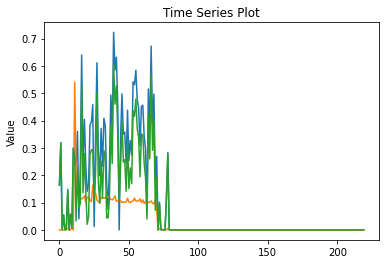

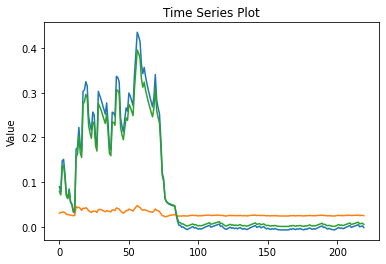

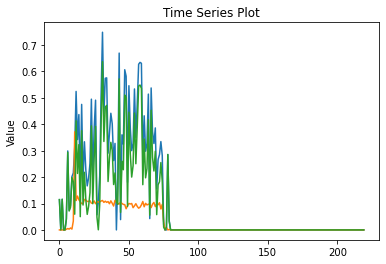

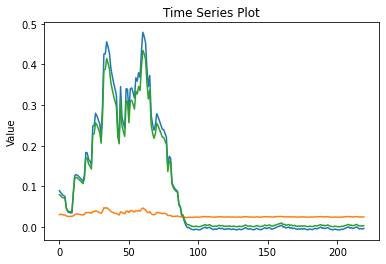

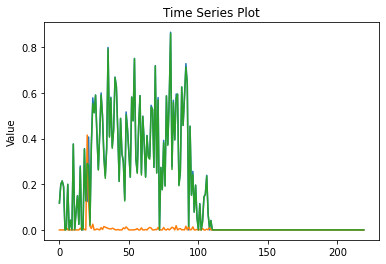

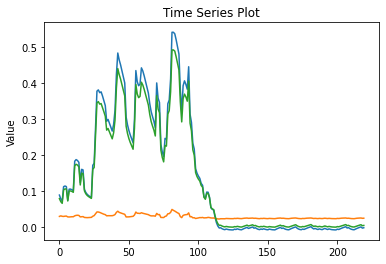

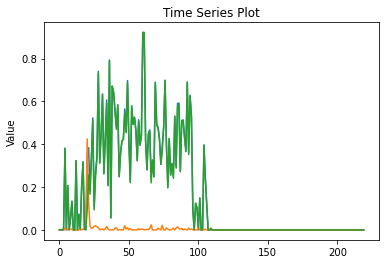

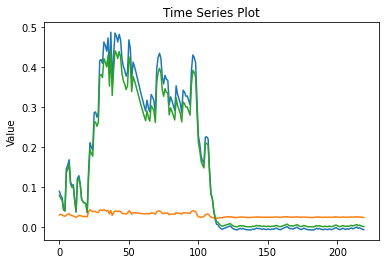

[tensor(0.0079), tensor(0.0081), tensor(0.0133), tensor(0.0141)]


In [11]:

test_loader = DataLoader(test_set, shuffle=False, batch_size=1)

reconstruction_errors = []

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        reconstructed = model.forward(x)
        # plt.plot(reconstructed[0, :, 0])
        plt.plot(x[0, :, 0])
        plt.plot(x[0, :, 1])
        plt.plot(x[0, :, 2])
        plt.title("Time Series Plot")
        plt.ylabel("Value")
        plt.show()
        # plt.plot(reconstructed[0, :, 1])
        # plt.title("Time Series Plot")
        # plt.ylabel("Value")
        # plt.show()
        
        plt.plot(reconstructed[0, :, 0])
        plt.plot(reconstructed[0, :, 1])
        plt.plot(reconstructed[0, :, 2])
        plt.title("Time Series Plot")
        plt.ylabel("Value")
        plt.show()
        reconstruction_errors.append(autoencoder_criterion(reconstructed, x))
        
print(reconstruction_errors)

In [9]:


with torch.no_grad():

  for x, y_true in test_loader:
    y_scores = model.forward(x)
    print(y_scores, y_true)
    fpr, fnr, thresholds = det_curve(y_true, y_scores)
    print(fpr, fnr)

tensor([[0.9491],
        [0.9442],
        [0.1443],
        [0.1323]]) tensor([1., 1., 0., 0.])
[0.] [0.]
